<a href="https://colab.research.google.com/github/Flaviofrc97/DASCIENSE-MACHINE-LEARNING/blob/main/Analise_dist_medicamentos_covd19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTS**

In [584]:
#!pip install systools

In [585]:
import pandas as pd
import calendar
import numpy as np

from systemtools.number import *

from pandas.api.types import is_string_dtype, is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns

In [586]:
sns.set(style='darkgrid')

def get_label(g):
  for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{}'.format(round(height)),
            ha="center", color='black')

# **READING DATA**

In [587]:
df = pd.read_csv('/content/DistribuicaoCloroquinaOseltamivir (2).csv', encoding = 'utf8', sep=';')

# **DATA DESCRIPTION**

In [588]:
df.tail()

,REGIÃO,UF,DESTINATARIO,LOCALIDADE,ITEM,PROGRAMA DE SAÚDE,QUANTIDADE,STATUS,DATA DE ENTREGA,VALOR UNITÁRIO,VALOR TOTAL
976,SUL,SANTA CATARINA,SES,SANTA CATARINA,FOSFATO DE OSELTAMIVIR 30MG,INFLUENZA,10000,ENTREGA REALIZADA,19/04/2021,"R$ 2,60","R$ 26.000,00"
977,SUDESTE,SÃO PAULO,SMS,SÃO PAULO,FOSFATO DE OSELTAMIVIR 30MG,INFLUENZA,100000,ENTREGA REALIZADA,20/04/2021,"R$ 2,60","R$ 260.000,00"
978,SUDESTE,ESPÍRITO SANTO,SMS,VITÓRIA,FOSFATO DE OSELTAMIVIR 30MG,INFLUENZA,1000,ENTREGA REALIZADA,19/04/2021,"R$ 2,60","R$ 2.600,00"
979,SUDESTE,MINAS GERAIS,SMS,BELO HORIZONTE,FOSFATO DE OSELTAMIVIR 75MG,INFLUENZA,35000,ENTREGA REALIZADA,26/04/2021,"R$ 5,00","R$ 175.000,00"
980,SUDESTE,SÃO PAULO,SMS,PRESIDENTE PRUDENTE,HIDROXICLOROQUINA 200MG,COVID-19,100000,ENTREGA REALIZADA,27/04/2021,R$ -,R$ -


In [589]:
df.shape

(981, 11)

In [590]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   REGIÃO             981 non-null    object
 1   UF                 981 non-null    object
 2   DESTINATARIO       981 non-null    object
 3   LOCALIDADE         981 non-null    object
 4   ITEM               981 non-null    object
 5   PROGRAMA DE SAÚDE  981 non-null    object
 6   QUANTIDADE         981 non-null    int64 
 7   STATUS             981 non-null    object
 8   DATA DE ENTREGA    981 non-null    object
 9    VALOR UNITÁRIO    981 non-null    object
 10   VALOR TOTAL       981 non-null    object
dtypes: int64(1), object(10)
memory usage: 84.4+ KB


In [591]:
df.isna().sum()

REGIÃO               0
UF                   0
DESTINATARIO         0
LOCALIDADE           0
ITEM                 0
PROGRAMA DE SAÚDE    0
QUANTIDADE           0
STATUS               0
DATA DE ENTREGA      0
 VALOR UNITÁRIO      0
 VALOR TOTAL         0
dtype: int64

# **FEATURE ENGINEERING**

In [592]:
df.sample()

,REGIÃO,UF,DESTINATARIO,LOCALIDADE,ITEM,PROGRAMA DE SAÚDE,QUANTIDADE,STATUS,DATA DE ENTREGA,VALOR UNITÁRIO,VALOR TOTAL
226,SUL,SANTA CATARINA,SMS,PINHALZINHO,HIDROXICLOROQUINA 200MG,COVID-19,3000,ENTREGA REALIZADA,17/09/2020,R$-,R$-


In [593]:
df.columns = df.columns.str.strip()
df.columns = df.columns.str.lower()

# Tirando espaços das linhas
for col in df:
  if is_string_dtype:
    df[col] = df[col].apply(lambda x: str(x).strip())


#Convrtendo o tipo
df['quantidade'] = df['quantidade'].astype('int64')
df['data de entrega'] = pd.to_datetime(df['data de entrega'], format='%d/%m/%Y')
df['ano'] = df['data de entrega'].dt.year
df['mes'] = df['data de entrega'].dt.month

#Retirando caracteres indesejados das colunas vr. unitario e vr. total e convertendo para float
df['valor unitário'] = df['valor unitário'].apply(lambda x: parseNumber(x))
df['valor total'] = df['valor total'].apply(lambda x: parseNumber(x))

# mudando numero do mes para o nome
df['nome mes'] = df['mes'].apply(lambda x: calendar.month_abbr[x])
df.drop(['destinatario', 'localidade', 'mes'], axis=1, inplace=True)

#Renomeando colunas
cols = ['regiao', 'uf', 'item', 'programa_saude', 'quantidade', 'status',
       'data_entrega', 'valor_unitario', 'valor_total', 'ano', 'nome_mes']

df.columns = map(str.lower,cols)

# **Fill NA**

In [595]:
df.dtypes

regiao                    object
uf                        object
item                      object
programa_saude            object
quantidade                 int64
status                    object
data_entrega      datetime64[ns]
valor_unitario           float64
valor_total              float64
ano                        int64
nome_mes                  object
dtype: object

# **EXPLORATORY DATA ANALYSIS**

In [596]:
# Estou separando apenas os dados referente a covid-19 e com Status de entregue, uma vez que não consigo analisar o que seria 'remanejamento'.
mask = (df['programa_saude'] == 'COVID-19') & (df['status'] == 'ENTREGA REALIZADA')
df_covid = df.loc[mask]

In [597]:
df_covid.head()

,regiao,uf,item,programa_saude,quantidade,status,data_entrega,valor_unitario,valor_total,ano,nome_mes
6,SUL,SANTA CATARINA,DIFOSFATO DE CLOROQUINA 150MG,COVID-19,1500,ENTREGA REALIZADA,2020-08-24,NaN,NaN,2020,Aug
7,SUL,RIO GRANDE DO SUL,DIFOSFATO DE CLOROQUINA 150MG,COVID-19,500,ENTREGA REALIZADA,2020-08-18,NaN,NaN,2020,Aug
8,SUL,RIO GRANDE DO SUL,DIFOSFATO DE CLOROQUINA 150MG,COVID-19,40000,ENTREGA REALIZADA,2020-08-18,NaN,NaN,2020,Aug
9,SUL,RIO GRANDE DO SUL,DIFOSFATO DE CLOROQUINA 150MG,COVID-19,9000,ENTREGA REALIZADA,2020-08-18,NaN,NaN,2020,Aug
10,SUL,RIO GRANDE DO SUL,DIFOSFATO DE CLOROQUINA 150MG,COVID-19,500,ENTREGA REALIZADA,2020-08-18,NaN,NaN,2020,Aug


In [598]:
aux = df_covid.groupby(['uf'])['quantidade'].sum().reset_index()
aux = pd.DataFrame(aux)
top10 = aux.nlargest(10, 'quantidade')

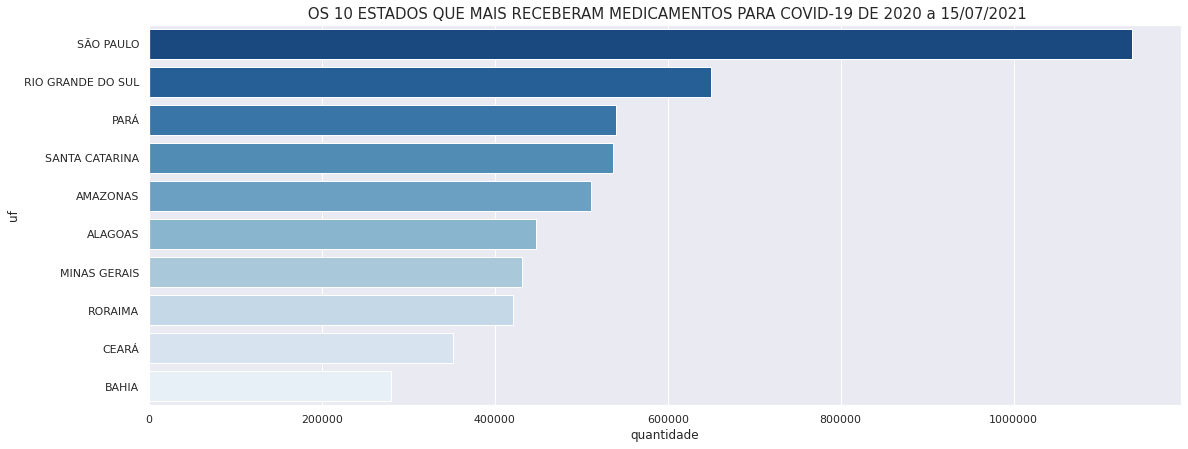

In [599]:
plt.figure(figsize=(18.5,7))
g = sns.barplot(y='uf', x='quantidade', data = top10, palette='Blues_r');
plt.title(' OS 10 ESTADOS QUE MAIS RECEBERAM MEDICAMENTOS PARA COVID-19 DE 2020 a 15/07/2021', size = 15);
plt.ticklabel_format(style='plain', axis='x')
#get_label(g)

In [600]:
aux2 = df_covid.groupby(['regiao'])['quantidade'].sum().reset_index()
aux2 = pd.DataFrame(aux2)
aux2 = aux2.nlargest(10, 'quantidade')

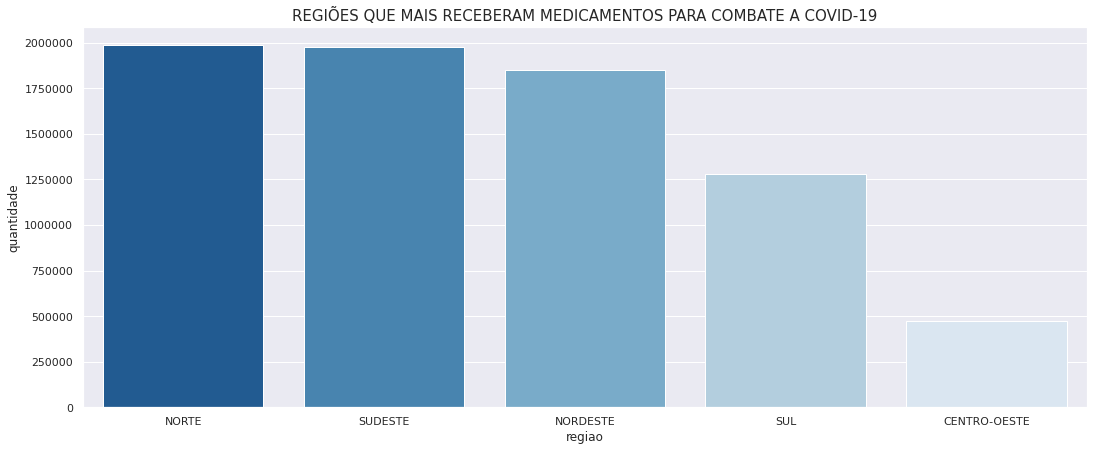

In [601]:
plt.figure(figsize=(18,7));
g = sns.barplot(x='regiao', y='quantidade', data = aux2, palette='Blues_r');
plt.title('REGIÕES QUE MAIS RECEBERAM MEDICAMENTOS PARA COMBATE A COVID-19',  size=15);
plt.ticklabel_format(style='plain', axis='y')
#get_label(g)

In [602]:
df_covid_2020 = df_covid[df_covid['data_entrega'].dt.year == 2020]

aux3 = df_covid_2020.groupby(['nome_mes'])['quantidade'].sum().reset_index()
aux3 = pd.DataFrame(aux3)

aux3['nome_mes']= pd.Categorical(aux3['nome_mes'],categories=['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Dec'],ordered=True)
aux3 = aux3.sort_values('nome_mes',ascending=False)

aux3

,nome_mes,quantidade
2,Dec,12000
7,Oct,15000
8,Sep,1056000
1,Aug,801000
3,Jul,870200
4,Jun,1582500
6,May,1602000
0,Apr,830000
5,Mar,500000


Text(0.5, 0, 'Mês')

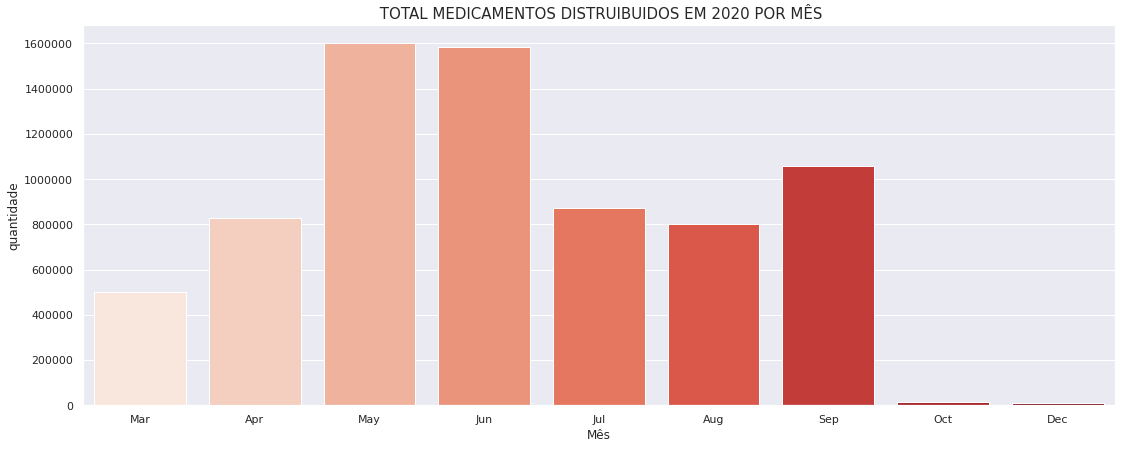

In [603]:
plt.figure(figsize=(18.5,7))
g = sns.barplot(x='nome_mes', y='quantidade', data = aux3, palette='Reds');
plt.title(' TOTAL MEDICAMENTOS DISTRUIBUIDOS EM 2020 POR MÊS', size=15);
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Mês')

In [604]:
df_covid_2021 = df_covid[df_covid['data_entrega'].dt.year == 2021]

aux4 = df_covid_2021.groupby(['nome_mes'])['quantidade'].sum().reset_index()
aux4 = pd.DataFrame(aux4)

aux4['nome_mes']= pd.Categorical(aux4['nome_mes'],categories=['Jan', 'Mar', 'Apr'],ordered=True)
aux4 = aux4.sort_values('nome_mes',ascending=False)

aux4

,nome_mes,quantidade
0,Apr,100000
2,Mar,27500
1,Jan,167000


Text(0.5, 0, 'Mês')

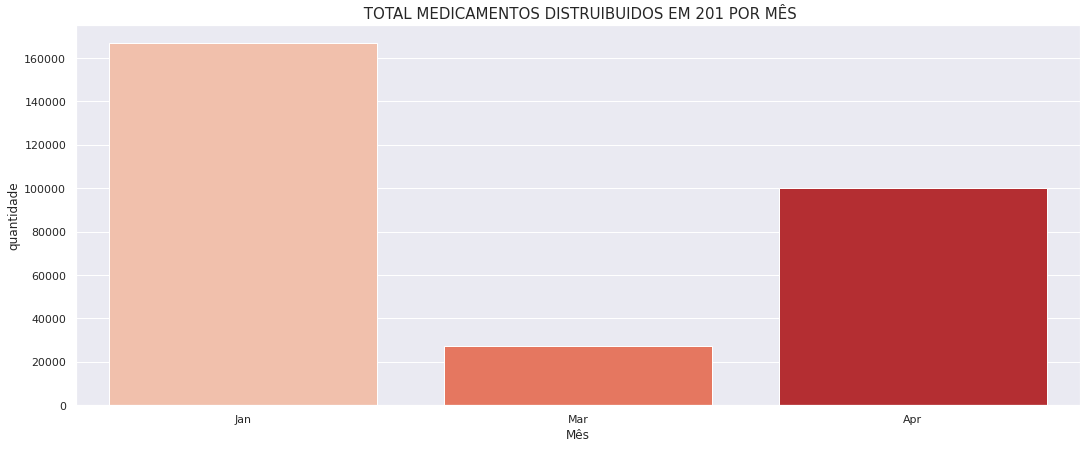

In [605]:
plt.figure(figsize=(18,7))
g = sns.barplot(x='nome_mes', y='quantidade', data = aux4, palette='Reds');
plt.title(' TOTAL MEDICAMENTOS DISTRUIBUIDOS EM 201 POR MÊS', size = 15);
plt.xlabel('Mês')

In [606]:
df_covid_test = df_covid[df_covid['data_entrega'].dt.year == 2021]

aux5 = df_covid_test.groupby(['nome_mes','uf'])['quantidade'].sum().reset_index()
aux5 = pd.DataFrame(aux5)

aux5['nome_mes']= pd.Categorical(aux5['nome_mes'],categories=['Jan', 'Mar', 'Apr'],ordered=True)
aux5 = aux5.sort_values('nome_mes',ascending=False)

aux5

,nome_mes,uf,quantidade
0,Apr,SÃO PAULO,100000
4,Mar,SÃO PAULO,27500
1,Jan,AMAZONAS,130000
2,Jan,MINAS GERAIS,13000
3,Jan,RIO GRANDE DO SUL,24000


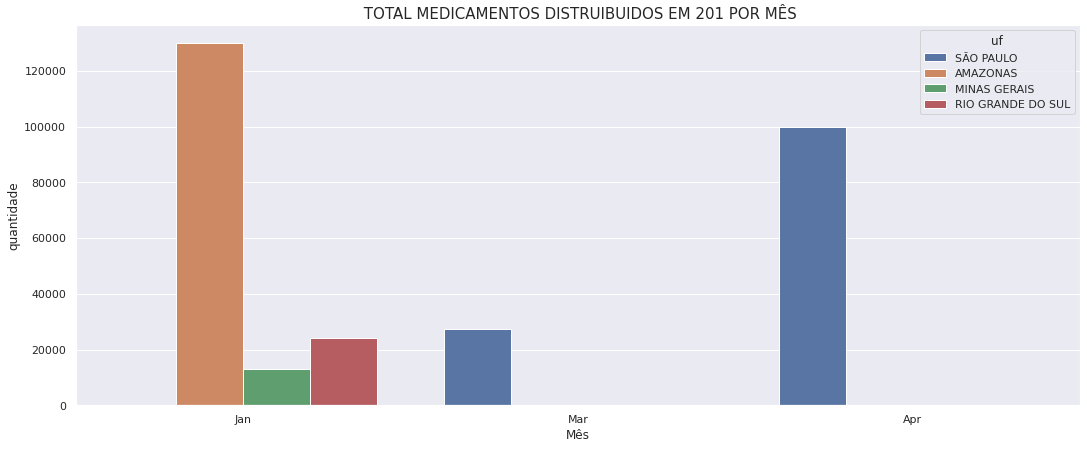

In [607]:
plt.figure(figsize=(18,7))
g = sns.barplot(x='nome_mes', y='quantidade', hue='uf', data = aux5);
plt.title(' TOTAL MEDICAMENTOS DISTRUIBUIDOS EM 201 POR MÊS', size = 15);
plt.xlabel('Mês');